# Part 4. Final Model, Mis-classification & Success Predictions Analysis

---

## Importing Libraries

In [1]:
# Importing the usual
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import joblib
import joblib

# Import NLP library
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Importing classification model
from sklearn.linear_model import LogisticRegression

# Importing Optimzation Tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Import metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,\
ConfusionMatrixDisplay

In [2]:
# Set option to display more text
pd.set_option('max_colwidth', 1000)

# Suppress slicing of copy dataframe - as we will make copies
pd.options.mode.chained_assignment = None

---

## Preparation

### Read datasets

In [3]:
# Read csv
post_df = pd.read_csv('../datasets/coursera_edx_posts_cleaned.csv',
                      index_col=[0])

cmt_df = pd.read_csv('../datasets/coursera_edx_comments_cleaned.csv',
                     index_col=[0])

### Stopwords

In [4]:
# Manually adding stopwords
manual_stopwords = stopwords.words('english')

# List of keywords to add
edx_list = ['edx','http','www','org'] 
coursera_list = ['coursera']

# Add to stopwords
manual_stopwords.extend(edx_list)
manual_stopwords.extend(coursera_list)

### Modeling with Title

In [5]:
# Select X and y.values
X = post_df['title_lemma'].values.astype('U')
y = post_df['subreddit']

In [6]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,
                                                 random_state=42)

In [7]:
# Check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1495,), (499,), (1495,), (499,))

In [8]:
# Check balance y_train
y_train.value_counts()

coursera    749
edx         746
Name: subreddit, dtype: int64

In [9]:
# Check balance y_test
y_test.value_counts()

coursera    250
edx         249
Name: subreddit, dtype: int64

**The baseline for all our models is 50%, which is the majority class**

### Load Model

In [10]:
lr_gs = joblib.load("../model/lr_model.pkl")

In [11]:
# check parameters
lr_gs.best_params_

{'lr__C': 0.4,
 'lr__n_jobs': -1,
 'tf__max_df': 0.4,
 'tf__max_features': 1000,
 'tf__ngram_range': (1, 1)}

### Borrowing function from model comparison

In [12]:
def fit_pipe(pipe,X_train,X_test,y_train,y_test):
    # Fit model
    pipe.fit(X_train,y_train)

    # Predict model
    y_pred = pipe.predict(X_test)
    
    # Show score
    print(f"Train Score: {pipe.score(X_train,y_train).round(4)}")
    print(f"Test Score: {pipe.score(X_test,y_test).round(4)}")
    
    # Print report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [13]:
def show_cm(pipe,X_train,X_test,y_train,y_test):
    # Fit model
    pipe.fit(X_train,y_train)

    # Predict model
    y_pred = pipe.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    
    print("Confusion Matrix:")
    ConfusionMatrixDisplay(cm,display_labels=['Coursera','EdX']).plot()
    plt.show();

### Borrowing Functions from EDA

In [14]:
# Create a function to vectorize and return dataframe

def vec_to_df(vec=CountVectorizer(),data=post_df['title']):
    # Vectorize using own choice and return vectorized dataframe
    
    # fit transform title
    d = vec.fit_transform(data)
    
    # Storing into a DataFrame
    df_vec = pd.DataFrame(d.todense(),columns=vec.get_feature_names_out())
    
    return df_vec

In [15]:
# Create a function to plot top recurring words

def plot_top_words(left_df,right_df,
                   top_n=15,title='Top 15 Words'):
    # Plot a comparison of top words mac vs windows
    
    # Generate figures
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),sharex=True)
    
    # Plot for Udemy
    left_df.sum().sort_values(ascending=False).head(top_n).\
    plot(kind='barh', ax=ax1, color = '#010000')
    ax1.set_title('EdX')
    
    # Plot for Coursera
    right_df.sum().sort_values(ascending=False).head(top_n).\
    plot(kind='barh', ax=ax2, color = '#0255d1')
    ax2.set_title('Coursera')
    
    # Plot suptitle
    plt.suptitle(title)
    plt.tight_layout()

In [16]:
def compare_words(left_df, right_df, vec_choice='cv', grams=(1,1), top_n=15, feature = 'title',
                  title='Top 15 Words',):
    
    # Select vectorizer and combine vec_to_df and plot_top_words
    
    # Selecting vectorizer choice
    if vec_choice == 'cv':
        vec = CountVectorizer(stop_words=manual_stopwords,
                              ngram_range=grams)
    elif vec_choice == 'tf':
        vec = TfidfVectorizer(stop_words=manual_stopwords,
                              ngram_range=grams)
            
    # Split mac and window then vectorize   
    edx_df  = vec_to_df(vec=vec,data=left_df[feature])
    coursera_df  = vec_to_df(vec=vec,data=right_df[feature])
    
    # Plot to compare
    plot_top_words(left_df = edx_df,
                   right_df = coursera_df,
                   top_n = top_n,
                   title = title)

---

## Logistic Regression

__*Check performance of loaded model*__

In [17]:
# Create Pipeline with loaded GridSearchCV parameters
lr_pipe_best = Pipeline([
    # Step 1. Vectorizer
    ('tf', TfidfVectorizer(max_df=lr_gs.best_params_['tf__max_df'],
                           max_features=lr_gs.best_params_['tf__max_features'],
                           ngram_range=lr_gs.best_params_['tf__ngram_range'],
                           stop_words=manual_stopwords)),
    # Step 2. Estimator
    ('lr', LogisticRegression(C=lr_gs.best_params_['lr__C'],
                              n_jobs=lr_gs.best_params_['lr__n_jobs'],
                              random_state=42))
])

In [18]:
fit_pipe(lr_pipe_best,X_train,X_test,y_train,y_test)

Train Score: 0.8441
Test Score: 0.6954
Classification Report:
              precision    recall  f1-score   support

    coursera       0.72      0.65      0.68       250
         edx       0.68      0.74      0.71       249

    accuracy                           0.70       499
   macro avg       0.70      0.70      0.69       499
weighted avg       0.70      0.70      0.69       499



Confusion Matrix:


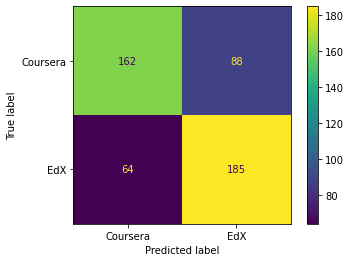

In [19]:
show_cm(lr_pipe_best,X_train,X_test,y_train,y_test)

---

## Investigating misclassification

Investigating misclassification will be done by generating a dataframe of wrong predictions and trained datasets. Which will then be used to evaluate where the model went wrong in those predictions. We will separate our investigation into two groups - *False Positve* and *False Negative*.

**Note:** <br>
- Positive = EdX
- Negative = Coursera

- False postive = predicted EdX but actually Coursera
- False negative = predicted Coursera but actually Edx

### Generating wrong predictions from test set

In [20]:
# Generating wrong predictions dataframe

# Generate predictions
y_pred = lr_gs.predict(X_test)

# Match with results
results = pd.DataFrame({'X_test':X_test,'y_test':y_test,'y_pred':y_pred})

# Generate predict probability
predict_df = pd.DataFrame(lr_gs.predict_proba(X_test),
                          columns=['Coursera','EdX'],index=results.index)

# Generate prediction dataframe
predictions = pd.concat([results,predict_df],axis=1)

# Select only wrong predictions
wrong = pd.DataFrame(predictions[predictions['y_test']!=predictions['y_pred']])

Separating false positives from false negatives

In [21]:
# False positive
false_positive = wrong[(wrong['y_test']=='coursera') & \
                       (wrong['y_pred']=='edx')]
# False negative
false_negative = wrong[(wrong['y_test']=='edx') & \
                       (wrong['y_pred']=='coursera')]

### Generating vectorized train dataset

In [22]:
# Borrowing function from 03_model_comparison notebook

def vec_to_df(vec=CountVectorizer(),data=post_df):
    # Vectorize using own choice and return vectorized dataframe
    
    # fit transform title
    d = vec.fit_transform(data)
    
    # Storing into a DataFrame
    df_vec = pd.DataFrame(d.todense(),columns=vec.get_feature_names_out())
    
    return df_vec

In [23]:
# Store original training data into dataframe and reset index
train = pd.DataFrame({'X_train':X_train,'y_train':y_train})

# Vectorize training data
X_vec_df = vec_to_df(vec=CountVectorizer(stop_words=manual_stopwords),
                     data=X_train).set_index(train.index)

# Concat to train_df
train_df = pd.concat([train,X_vec_df],axis=1)

### Separating Mis-classification

We will create two columns to help us with evaluation. 
<br>
1. how_likely
    - Count how many of each word shows up in training data labeled as `edx` and `coursera`
    - Taking showing up for `edx` labeled as positive and `coursera` as negative
    - Sum up the differences in words showing up in training data for each label
    - Positve means more of the words are labeled `edx`, negative means `coursera`
    
2. how_likely_single
    - Same as *how_likely* but each word will be counted as +1 or -1

In [24]:
def how_likely(string):
    # Function to generate differences in word counts by total counts
    # EdX + 1 / Coursera -1
    diff = 0
    for word in string.split():
        # if words in edx diff + wordcount
        try:
            diff += train_df[train_df['y_train']=='edx'][word].sum()
        except:
            pass
        # if words in coursera diff - wordcount
        try:
            diff -= train_df[train_df['y_train']=='coursera'][word].sum()
        except:
            pass
        
    return diff

In [25]:
def how_likely_single(string):
    # Function to generate differences in word counts by number of words

    # EdX + 1 / Coursera -1
    diff = 0
    
    for word in string.split():
        # Count words
        try:
            edx_count = train_df[train_df['y_train']=='edx'][word].sum()
        except:
            edx_count = 0
        try:
            coursera_count = train_df[train_df['y_train']=='coursera']\
            [word].sum()
        except:
            coursera_count = 0
            
        # compare counts
        if edx_count > coursera_count:
            diff += 1
        elif edx_count < coursera_count:
            diff -= 1
        else:
            pass
        
    return diff

#### Generating `likely_total` and `likely_single` on Training Data

In [26]:
# Generate likely_total and likely_single column
train_df['likely_total'] = train_df['X_train'].apply(how_likely)
train_df['likely_single'] = train_df['X_train'].apply(how_likely_single)

#### False Positive

Generate `likely_total` and `likely_single` column in the `flase_positive` DataFrame

In [27]:
false_positive['likely_total'] = false_positive['X_test'].apply(how_likely)

In [28]:
false_positive['likely_single'] = false_positive['X_test'].apply(how_likely_single)

Investigate relationship between `likely_single` and probability of predicting `edx`

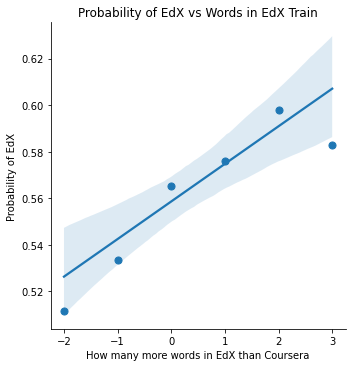

In [29]:
sns.lmplot(y='EdX',x='likely_single',data=false_positive,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of EdX vs Words in EdX Train')
plt.ylabel('Probability of EdX')
plt.xlabel('How many more words in EdX than Coursera');

**Key Takeaway:** <br>
- The more words that show up in training data that are labeled `edx`, the more probability the model will predict the title to be from `edx` subreddit
- From this visualization we can breakdown the false positives to three cases:
    1. word count = 0
    2. word count more towards `edx`
    3. word count more towards `coursera`

#### Cause of Error 1. Word Count = 0

In [30]:
# False positive where both likely and likely_1 is more than 0
false_positive[(false_positive['likely_single']==0) & \
               (false_positive['likely_total']==0)]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
1808,coursera tesol certif,coursera,edx,0.472913,0.527087,0,0
2058,finding a course to learn about renewables,coursera,edx,0.478949,0.521051,0,0
1749,freelance career for socially anxious people,coursera,edx,0.490198,0.509802,0,0
1845,paid course at coursera,coursera,edx,0.484158,0.515842,0,0
1700,is there a slack workspace for coursera course,coursera,edx,0.438725,0.561275,0,0
1332,is this transferable,coursera,edx,0.472913,0.527087,0,0
1366,nan,coursera,edx,0.472913,0.527087,0,0


#### Case 1. Words didn't show up in training labeled `edx` and `coursera` - due to short title

In [31]:
# filtering both equal 0 
train_df[(train_df['likely_total']==0)&(train_df['likely_single']==0)]\
['y_train'].value_counts()

edx         15
coursera    12
Name: y_train, dtype: int64

**Key Takeaway:** <br>
- For titles with words that show up equally for `edx` and `coursera` on the training dataset
- This happens more often for those that are labeled `edx`
- Meaning for this case, the model will automatically select `edx` as prediction

#### Case 2. Words show up equally in training labeled `edx` and `coursera`

In [32]:
train_df[train_df['test']>0]['y_train'].value_counts()

edx         5
coursera    2
Name: y_train, dtype: int64

In [33]:
train_df[train_df['retake']>0]['y_train'].value_counts()

coursera    3
edx         1
Name: y_train, dtype: int64

#### Cause of Error 2. Word Count > 0 - topics discussed more in `coursera` subreddit

In [34]:
# False positive where likely_total and likely_single is more than 0
false_positive[(false_positive['likely_single']>0) & \
               (false_positive['likely_total']>0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
1729,full stack web development course what to do with node_modules folder when syncing file to a web hosting provider,coursera,edx,0.424151,0.575849,13,1
1818,using keyboard shortcut to play pause coursera video in the fullscreen mode,coursera,edx,0.420931,0.579069,17,2
1340,what course do you recommend taking,coursera,edx,0.400460,0.599540,7,1
1819,when i scroll down in a course video page the video is getting bigger,coursera,edx,0.441260,0.558740,14,1
1884,delay in subtitle on the app,coursera,edx,0.389300,0.610700,8,3
2083,self paced learning what doe this mean,coursera,edx,0.372389,0.627611,8,3
1636,stumped on a star search question,coursera,edx,0.379431,0.620569,18,2
2060,question,coursera,edx,0.345048,0.654952,16,1
2224,doe coursera have a course similar to security,coursera,edx,0.462807,0.537193,6,1
1811,what happened to introduction to astronomy,coursera,edx,0.343815,0.656185,23,2


#### Case 1. Titles have topics that are dominated by `edx` subreddit

e.g. hse master of finance - finance courses are more dominated by `edx` as `coursera` are mostly tech related courses, additionally `edx` is partnered with universities and masters degree has been one of the main selling point for them.

In [35]:
train_df[train_df['finance']>0]['y_train'].value_counts()

edx         6
coursera    1
Name: y_train, dtype: int64

In [36]:
train_df[train_df['master']>0]['y_train'].value_counts()

edx         16
coursera     9
Name: y_train, dtype: int64

#### Case 2. Generic words that unformationately show up more in the `edx` subreddit

e.g. where to access live chat

In [37]:
train_df[train_df['access']>0]['y_train'].value_counts()

edx         23
coursera    17
Name: y_train, dtype: int64

In [38]:
train_df[train_df['live']>0]['y_train'].value_counts()

edx         4
coursera    4
Name: y_train, dtype: int64

#### Cause of Error 3. Word Count < 0 - topics discussed more in `coursera` in terms of number of words not necessarily word frequency

In [39]:
# False positive where likely_total and likely_single is more than 0
false_positive[(false_positive['likely_single']<0) & \
               (false_positive['likely_total']<0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
2024,looking for course to get with programming,coursera,edx,0.476431,0.523569,-3,-2
2172,help how do i create a community page on coursera,coursera,edx,0.493373,0.506627,-6,-2
1343,down for maintenance,coursera,edx,0.472913,0.527087,-1,-1
1785,best coursera tech course master track certificate,coursera,edx,0.478915,0.521085,-19,-1
1705,doubt on coursera fee,coursera,edx,0.495316,0.504684,-3,-2
2120,50 off from select course until june 3,coursera,edx,0.454756,0.545244,-1,-1
2119,sharing a pdf certificate on your profile,coursera,edx,0.498566,0.501434,-25,-1
2188,cleaning up r coursera,coursera,edx,0.472913,0.527087,-1,-1
1926,coursera s gtc,coursera,edx,0.472913,0.527087,-1,-1
1518,is this legit,coursera,edx,0.472913,0.527087,-1,-1


#### Case 1. Title have words that show up in `Coursera` subreddit but outweight by default prediction of `edx`

e.g. cleaning up r coursera

In [40]:
train_df[train_df['cleaning']>0]['y_train'].value_counts()

coursera    1
Name: y_train, dtype: int64

e.g. public health on cousera

In [41]:
train_df[train_df['public']>0]['y_train'].value_counts()

coursera    3
edx         1
Name: y_train, dtype: int64

In [42]:
train_df[train_df['health']>0]['y_train'].value_counts()

coursera    1
Name: y_train, dtype: int64

#### False Negative

Generate `likely_total` and `likely_single` column in the `flase_positive` DataFrame

In [43]:
false_negative['likely_total'] = false_negative['X_test'].apply(how_likely)

In [44]:
false_negative['likely_single'] = false_negative['X_test']\
.apply(how_likely_single)

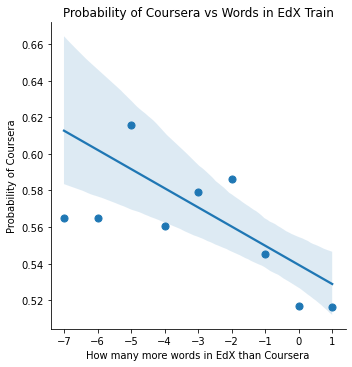

In [45]:
sns.lmplot(y='Coursera',x='likely_single',data=false_negative,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of Coursera vs Words in EdX Train')
plt.ylabel('Probability of Coursera')
plt.xlabel('How many more words in EdX than Coursera');

**Key Takeaway:** <br>
- The more words that show up in training data that are labeled `edx`, the less probability the model will predict the title to be from `coursera` subreddit
- From this visualization we can breakdown the false positives to three cases:
    1. word count = 0
    2. word count more towards `edx`
    3. word count more towards `coursera`

### Cause of Error 1. Word Count = 0 for `likely_single`

In [46]:
false_negative[(false_negative['likely_single']==0)]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
949,can t find any course about computer networking on edx,edx,coursera,0.533987,0.466013,2,0
553,shitty mooc platform,edx,coursera,0.515664,0.484336,0,0
566,is it worth it in my situation,edx,coursera,0.512905,0.487095,0,0
546,financial assistance result,edx,coursera,0.503457,0.496543,-41,0
762,getting a certificate for a program is it worth it how,edx,coursera,0.500648,0.499352,-23,0
669,account setting update issue edit disabled verification denied,edx,coursera,0.527714,0.472286,-13,0
103,new course,edx,coursera,0.514870,0.485130,-1,0
38,is paying for the certificate worth it,edx,coursera,0.501534,0.498466,-24,0
22,edx certificate worth,edx,coursera,0.540049,0.459951,-24,0
88,what are the best edx course for beginner in economics,edx,coursera,0.516879,0.483121,-2,0


#### Case 1. Title have same amount of words showing up in `edx` and `coursera` labeled training data, but the frequencies are different

e.g. how to finish a course

In [47]:
train_df[train_df['finish']>0]['y_train'].value_counts()

edx         6
coursera    5
Name: y_train, dtype: int64

In [48]:
train_df[train_df['course']>0]['y_train'].value_counts()

coursera    248
edx         240
Name: y_train, dtype: int64

### Cause of Error 2. Tite have more words showing up in `coursera subreddit`

In [49]:
false_negative[(false_negative['likely_single']<0)
               &(false_negative['likely_single']<0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
970,need help with cs50x,edx,coursera,0.606660,0.393340,-17,-2
419,financial aid,edx,coursera,0.803360,0.196640,-97,-2
126,just a doubt,edx,coursera,0.504226,0.495774,-2,-1
401,i m having trouble submitting the answer to the assignment i clicked submit once and then save after each answer but it still doesn t look like my answer got submitted and that my assignment is now complete and passed please help thank you,edx,coursera,0.594463,0.405537,-41,-6
682,how will this course help,edx,coursera,0.525082,0.474918,-8,-2
77,financial aid coupon,edx,coursera,0.617444,0.382556,-92,-1
820,should i continue,edx,coursera,0.501369,0.498631,-1,-1
404,photo id edx impossible to contact,edx,coursera,0.555922,0.444078,-9,-2
793,edx certificate removed because of deleted grade,edx,coursera,0.514485,0.485515,-26,-2
14,staying on top of learning on edx,edx,coursera,0.563531,0.436469,-18,-2


#### Case 1. Title have words showing up more in `coursera` training set

e.g. edx certification

In [50]:
train_df[train_df['certification']>0]['y_train'].value_counts()

coursera    21
edx          9
Name: y_train, dtype: int64

e.g. problem with cybermonday sale

In [51]:
train_df[train_df['problem']>0]['y_train'].value_counts()

coursera    12
edx          8
Name: y_train, dtype: int64

In [52]:
train_df[train_df['cybermonday']>0]['y_train'].value_counts()

edx    1
Name: y_train, dtype: int64

### Cause of Error 3. Tite have more words showing up in `edx` subreddit but doesn't outweight in frequency

In [53]:
false_negative[(false_negative['likely_single']>0)
               &(false_negative['likely_single']>0)][:10]

,X_test,y_test,y_pred,Coursera,EdX,likely_total,likely_single
773,what doe a computer science degree look like,edx,coursera,0.521929,0.478071,35,1
133,same answer to multiple financial assistance application,edx,coursera,0.511250,0.488750,-42,1
362,thousand of password reset email from edx in the last 24 hour how can i make this stop one every minute since 6pm last night and i do not use edx but have an old account,edx,coursera,0.531170,0.468830,-6,1
417,hi did someone take the justice course,edx,coursera,0.512991,0.487009,2,1
709,anyone who graduated from edx with a master s degree,edx,coursera,0.505382,0.494618,10,1


#### Case 1. Word frequency is higher for `coursera` due to topics of dicussion or simply generic terms

e.g. video lag - generic term

In [54]:
train_df[train_df['video']>0]['y_train'].value_counts()

edx         16
coursera     8
Name: y_train, dtype: int64

e.g. thought on edx certificate for blockchin worth it

In [55]:
train_df[train_df['thought']>0]['y_train'].value_counts()

edx         4
coursera    1
Name: y_train, dtype: int64

In [56]:
train_df[train_df['certificate']>0]['y_train'].value_counts()

coursera    109
edx          89
Name: y_train, dtype: int64

In [57]:
train_df[train_df['worth']>0]['y_train'].value_counts()

edx         14
coursera    13
Name: y_train, dtype: int64

## Summary of Mis-classification

All false positives and false negative can be traced back to 3 main root causes: <br>

1. Short titles that never show up on training dataset
2. Title regarding topics dominated by the other subreddit
3. Marginal differences outweighs by default predict probability

Ways to tackle these error could be:
1. Acquire more training dataset that enough words show up in the training dataset
2. Manually add more dominate words to stopwords with the trade off of reducing the overall accuracy
3. Join the title and comment string to add more training data, and reduces short titles

---

## Successful Predictions Analysis

In [58]:
# Select only wrong predictions
right = pd.DataFrame(predictions[predictions['y_test']==predictions['y_pred']])

In [59]:
# True positive
true_positive = right[(right['y_test']=='edx') & \
                       (right['y_pred']=='edx')]
# True negative
true_negative = right[(right['y_test']=='coursera') & \
                       (right['y_pred']=='coursera')]

In [60]:
# Create columns likely_total and likely_single - true positive
true_positive['likely_total'] = true_positive['X_test'].apply(how_likely)
true_positive['likely_single'] = true_positive['X_test'].apply(how_likely_single)

In [61]:
# Create columns likely_total and likely_single - true negative
true_negative['likely_total'] = true_negative['X_test'].apply(how_likely)
true_negative['likely_single'] = true_negative['X_test'].apply(how_likely_single)

### True Positive

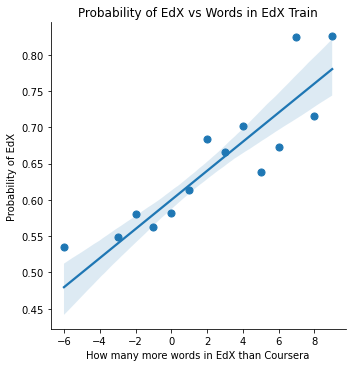

In [62]:
sns.lmplot(y='EdX',x='likely_single',data=true_positive,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of EdX vs Words in EdX Train')
plt.ylabel('Probability of EdX')
plt.xlabel('How many more words in EdX than Coursera');

### True Negative

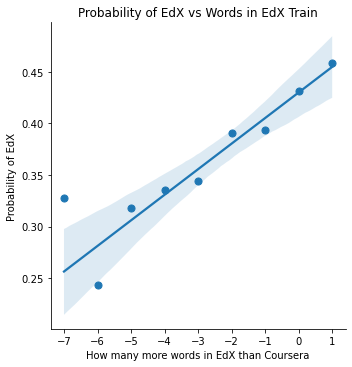

In [63]:
sns.lmplot(y='EdX',x='likely_single',data=true_negative,
           x_estimator=np.mean,x_ci=False)

plt.title('Probability of EdX vs Words in EdX Train')
plt.ylabel('Probability of EdX')
plt.xlabel('How many more words in EdX than Coursera');

## Visualizing Correct Predicitions

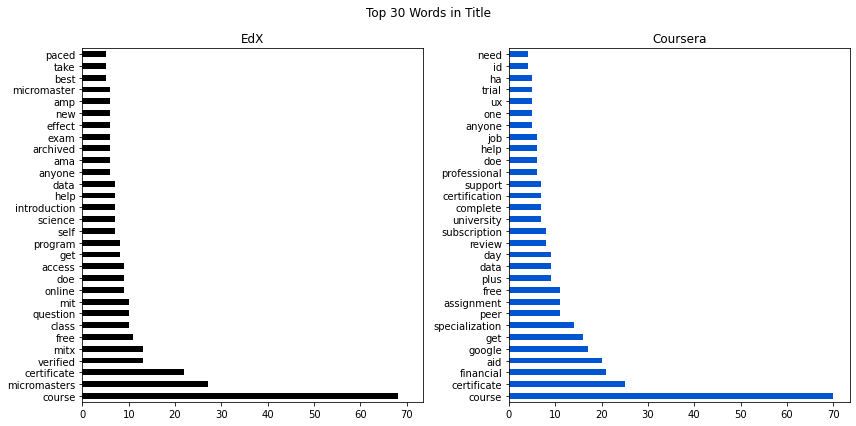

In [64]:
compare_words(left_df=true_positive, right_df = true_negative,
              vec_choice='cv',grams=(1,1),top_n=30, feature = 'X_test',
              title='Top 30 Words in Title')

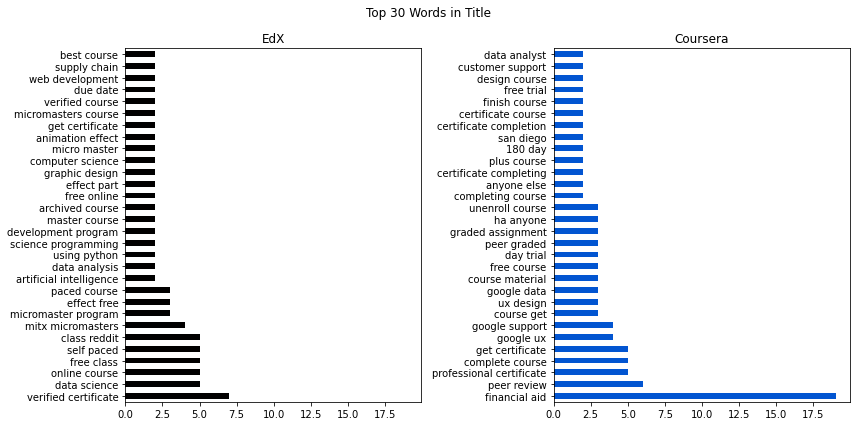

In [65]:
compare_words(left_df=true_positive, right_df = true_negative,
              vec_choice='cv',grams=(2,2),top_n=30, feature = 'X_test',
              title='Top 30 Words in Title')

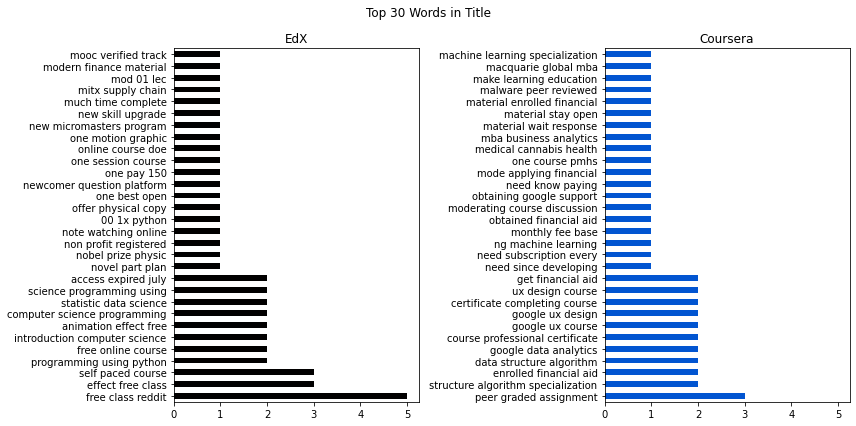

In [66]:
compare_words(left_df=true_positive, right_df = true_negative,
              vec_choice='cv',grams=(3,3),top_n=30, feature = 'X_test',
              title='Top 30 Words in Title')

## Summary of Predictions

All true positives and true negatives can be explained using similar approach to mis-classifications, combining all insights from EDA, modeling, and misclassification analysis we can conclude that for each platform to improve:

**1. *EdX*:** <br>
Current Strengths:
- University based courses e.g. Introduction to computer science
- MicroMaster program
- Audit score
- Some self-paced programs

To Improve:
- More verified certificates
- More self-paced courses
- Audit courses will generate new users
    

**2. *Coursera*:** <br>
Current Strengths:
- Industry-oriented courses in partnership with Google/IBM
- Professional certificate
- Financial Aid
- Self-paced

To Improve:
- Keep on driving business/industry related courses
- Improve customer support
- Improve platform, specifically log-in and chat bubbles